# Esercitazione 4: dinamica molecolare nell'insieme microcanonico

Il codice NSL_SIMULATOR che abbiamo fornito calcola l'energia totale (interna) per particella, $\frac{E}{N}$, l'energia potenziale per particella, $\frac{U}{N}$, l'energia cinetica per particella, $\frac{K}{N}$, e la temperatura, $T $.

In primo luogo ho incluso calcolo della pressione, $P$, all'interno del codice di Dinamica Molecolare, calcolando medie a blocchi, valori medi progressivi e incertezze progressive.

Ho usato la seguente formula del viriale per stimare la pressinone in un sistema di Lennard-Jones:

$$ P = \rho k_B \langle T \rangle + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$

In [144]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import shutil

phase = ["solid", "liquid","gas"]

def plotConfig(fileName,elevation,azimuth):
    fig = plt.figure(figsize=(10,8))
    X, Y, Z = np.loadtxt(fileName,usecols=(1,2,3), skiprows=2, unpack=True)
    ax = fig.add_subplot(121, projection='3d',proj_type='ortho')
    ax.scatter(X, Y, Z, c='blue', marker='.',s=100)
    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    bound=0.5
    ax.set_xlim(-bound,bound)
    ax.set_ylim(-bound,bound)
    ax.set_zlim(-bound,bound)
    #plot()
    plt.show()

In [161]:
# stampa le condizioni iniziali
# in modo leggibile
cartellaInput='../NSL_SIMULATOR/INPUT/'

def printInput(fileDiInput):
    lines = fileDiInput.split('\n')[:9]
    for line in lines:
        print(line)

# imposta le condizioni iniziali relative 
# alla fase (solido, liquido, gas)
# e la configurazione iniziale, che può essere di fcc
# o piuttosto di fase equilibrata.

def setInitialConfig(fase,initialConfig,\
                     Nblocchi,LStepBlocco,equilibration):
    with open(cartellaInput+\
              "INPUT_EXAMPLES/input."+fase, "r") as file:
        input_content = file.read()
    customInput=input_content.\
        replace('20\nNSTEPS                 2000', \
                str(Nblocchi)+'\nNSTEPS                 '+\
                str(LStepBlocco))
    customInput2=customInput
    if(equilibration):
        if(fase == 'solid'):
            startTemp=1.54
            customInput2=customInput.\
                replace('TEMP                   0.8',\
                    'TEMP                   '+str(startTemp))
        if(fase == 'liquid'):
            startTemp=2.0
            customInput2=customInput.\
                replace('TEMP                   1.1',\
                    'TEMP                   '+str(startTemp))
        if(fase=='gas'):
            startTemp=0.95    
            customInput2=customInput.\
                replace('TEMP                   1.2',\
                    'TEMP                   '+str(startTemp))
    
    with open(cartellaInput+"input.dat", "w") as file:
        file.write(customInput2)
        
    shutil.copyfile(initialConfig, cartellaInput+'CONFIG/config.xyz')
    fccTrue='fcc'
    if(not initialConfig==cartellaInput+'CONFIG/config.fcc'):
        fccTrue='equilibrio'
    print("HO IMPOSTATO LA CONFIGURAZIONE INIZIALE"+'\n'+
          fase+' '+fccTrue+' con')
    printInput(customInput2)
    plotConfig(cartellaInput+'CONFIG/config.xyz',0,0)

In [158]:
import subprocess
import os
import shutil


def runSimulation(fase, cartella_origine):
    os.chdir('../NSL_SIMULATOR/SOURCE/')
    subprocess.run('./simulator.exe')
    os.chdir('../')
    destination_dir='../4-moleculardynamicsnve/'\
                    +cartella_origine+fase
    shutil.rmtree(destination_dir, ignore_errors=True)
    shutil.copytree('OUTPUT',destination_dir )
    print('HO OTTENUTO LA CONFIGURAZIONE FINALE\n'+
          fase)
    os.chdir('../4-moleculardynamicsnve')
    plotConfig(cartella_origine+fase+'/CONFIG/config.xyz',0,0)
    
    
def plotData(cartella_origine, maxRows):
   # Teq = [ 0.8, 1.1, 1.2]
    Teq = [ 0.8,1.1,1.2]
    for i in range (0,3) :
        x, temp, temp_prog, temperr_prog = \
            np.loadtxt(cartella_origine+phase[i]+"/temperature.dat",\
            max_rows=maxRows,  skiprows=1, unpack=True)
        plt.figure(figsize=(15,7))
        plt.plot(x,temp, color='orange', label="Temperatura")
        plt.axhline(y=Teq[i], color ="r", label = "Target temperature: "+str(Teq[i]))
        plt.title(phase[i],fontsize=25)
        plt.xlabel('Passi',fontsize=15)
        plt.ylabel('Temperatura',fontsize=15)
        plt.legend(fontsize=20)
        plt.grid(True)
        plt.show()

# Equilibrazione del sistema

Monitorando la temperatura $T$, durante i primi passaggi della simulazione, osservo che all'inizio, partendo da una configurazione cristallina perfetta, $T$ non conserva il suo valore. Il motivo di ciò è che il sistema deve equilibrarsi termicamente, dato che un perfetto cristallo fcc è una configurazione molto fuori equilibrio.


In [160]:

print('do you want to execute this program:')
answer = input('->  [yes| No]: ' )
if answer == 'yes' :
    #Equilibrazione:
    for i in range (0,3) :
        setInitialConfig(phase[i],cartellaInput+'CONFIG/config.fcc',\
                         20000,1,True)
        runSimulation(phase[i],'equilibrazione/')

do you want to execute this program:


->  [yes| No]:  no


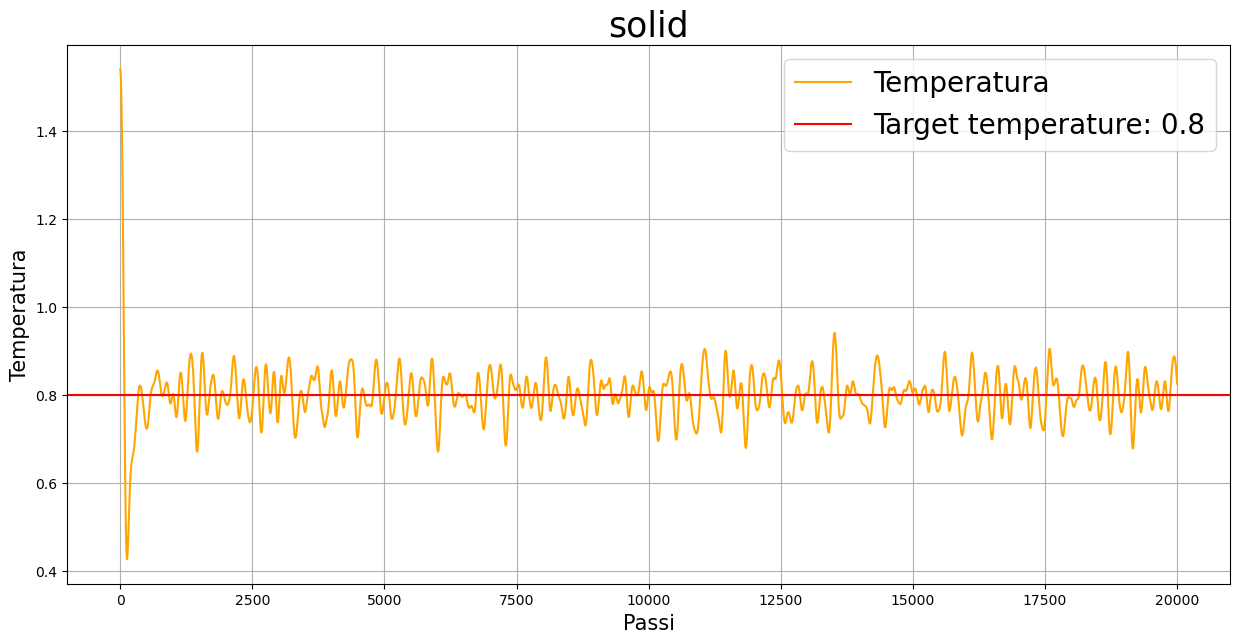

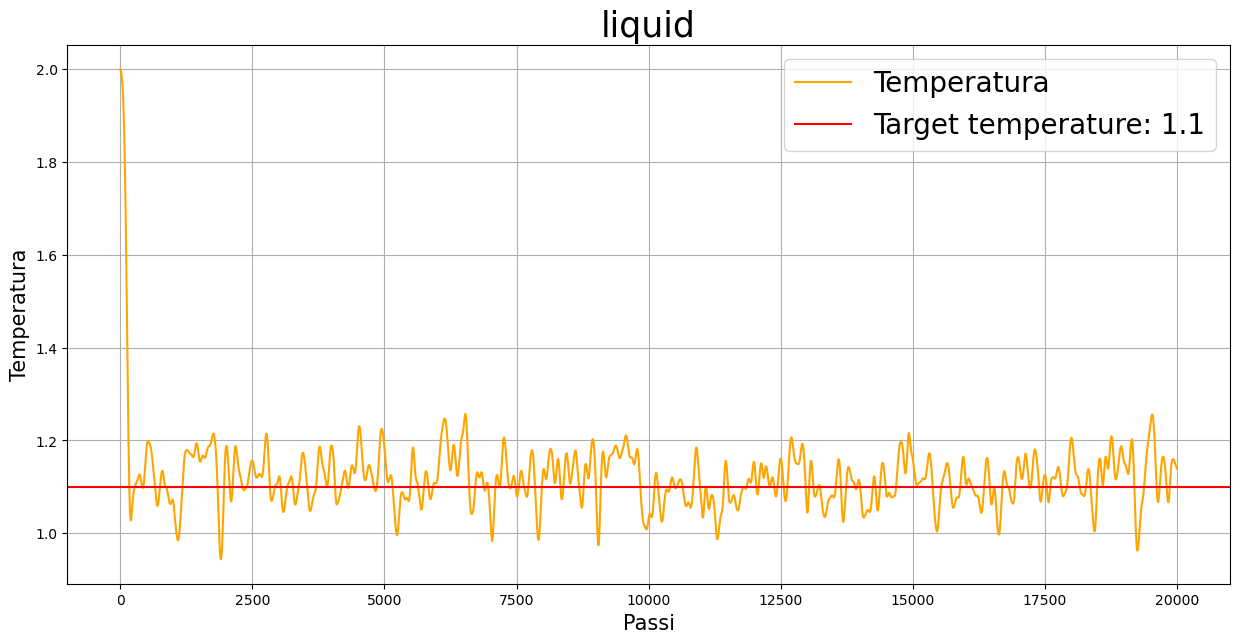

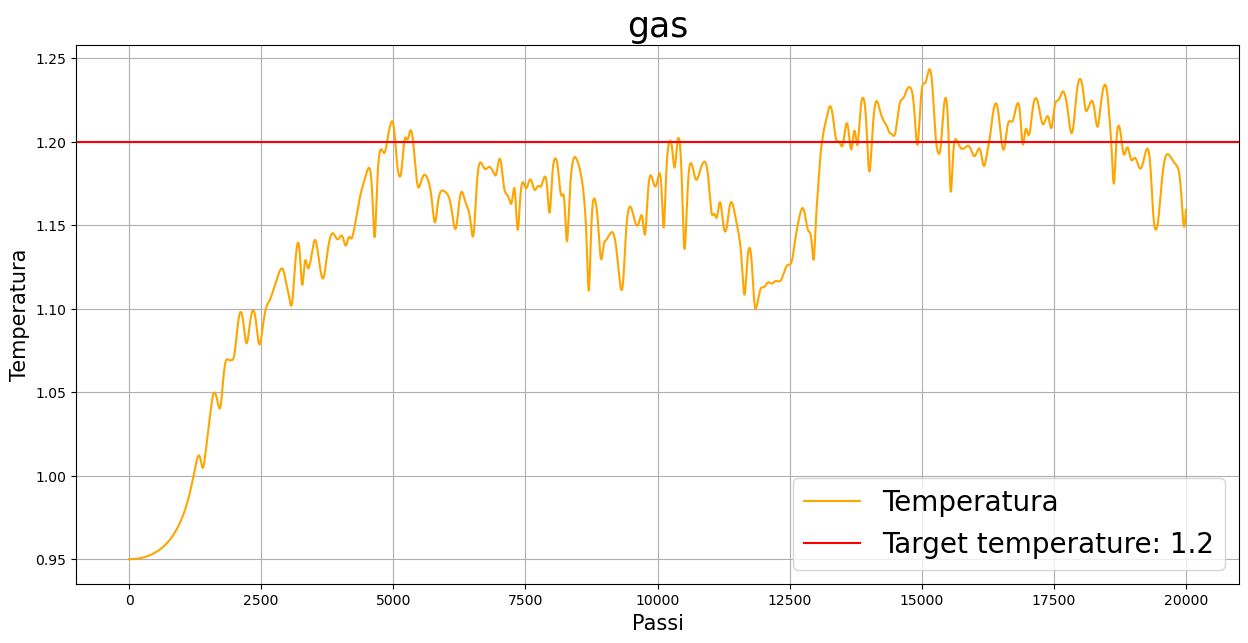

In [159]:
plotData('equilibrazione/',20000)

Si trova dunque:

| fase     | Solido   | Liquido  | Gas   |
|----------|----------|----------|-------|
|  $kT^*$  | 1.54     | 2.0      | 0.95  |




Ho trovato il valore iniziale di $T^*$ necessario per stabilizzare, il sistema dopo un certo numero di passaggi (tempo di equilibrazione). Imposto il valore medio di $T$ al valore desiderato $T^*$. Lancerò le simulazioni di Dinamica Molecolare di fase solida/liquida/gassosa in seguito a tale tempo di equilibrazione.

# Termalizzazione di un sistema di argon

Attraverso codice aggiornato, ho eseguito simulazioni di Dinamica Molecolare di un modello di Lennard-Jones per l'Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle seguenti condizioni:
1. fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cutoff: $r_c = 2.2$)
2. fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cutoff: $r_c = 2.5$)
3. fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cutoff: $r_c = 5.0$)


do you want to execute this program:


->  [yes| No]:  yes


HO IMPOSTATO LA CONFIGURAZIONE INIZIALE
solid equilibrio con
SIMULATION_TYPE        0
RESTART                0
TEMP                   0.8
NPART                  108
RHO                    1.1
R_CUT                  2.2
DELTA                  0.0005
NBLOCKS                50
NSTEPS                 2000


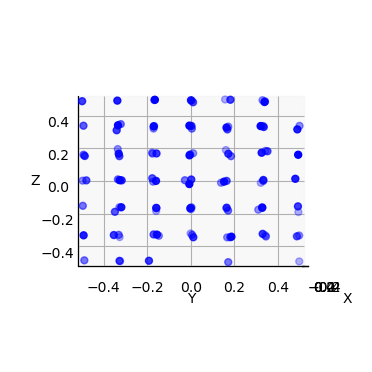

HO OTTENUTO LA CONFIGURAZIONE FINALE==== ] 98 %
solid


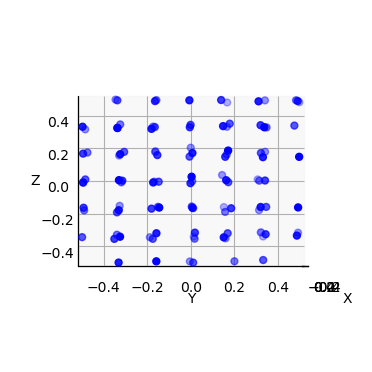

HO IMPOSTATO LA CONFIGURAZIONE INIZIALE
liquid equilibrio con
SIMULATION_TYPE        0
RESTART                0
TEMP                   1.1
NPART                  108
RHO                    0.8
R_CUT                  2.5
DELTA                  0.0005
NBLOCKS                50
NSTEPS                 2000


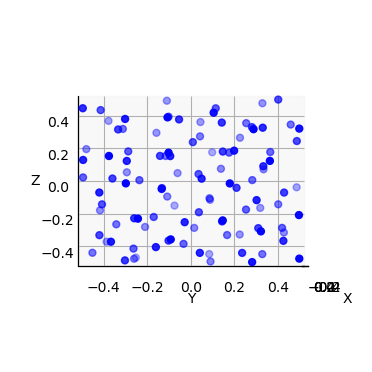

HO OTTENUTO LA CONFIGURAZIONE FINALE==== ] 98 %
liquid


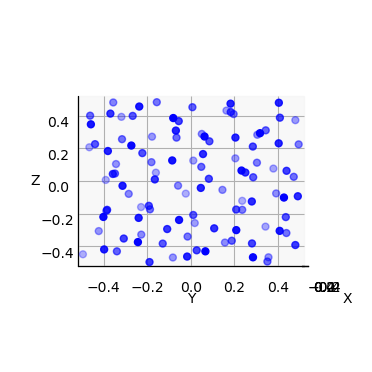

HO IMPOSTATO LA CONFIGURAZIONE INIZIALE
gas equilibrio con
SIMULATION_TYPE        0
RESTART                0
TEMP                   1.2
NPART                  108
RHO                    0.05
R_CUT                  5.0
DELTA                  0.0005
NBLOCKS                50
NSTEPS                 2000


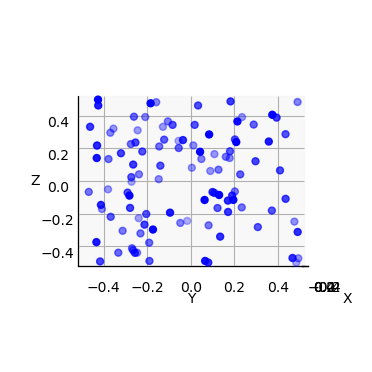

HO OTTENUTO LA CONFIGURAZIONE FINALE==== ] 98 %
gas


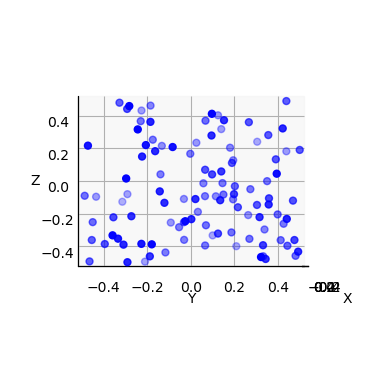

In [162]:
print('do you want to execute this program:')
answer = input('->  [yes| No]: ' )
if answer == 'yes' :
    for i in range (0,3) :
        setInitialConfig(phase[i],'equilibrazione/'+phase[i]+\
                         '/CONFIG/config.xyz',50,2000,False)
        runSimulation(phase[i],'argon/')

In [163]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

npart = 108

N = 50
x = np.arange(N)+1    # uso l'ordinamento da 1 a N

th_var = ["kinetic_energy", "potential_energy",\
          "total_energy", "pressure", "temperature"]
labels = [  "Kinetic en.\n(progr. average)",
            "Potential en.\n(progr. average)",
            "Total en.\n(progr. average)",
            "Pressure\n(progr. average)", 
            "Temperature\n(block average)",
            "Temperature\n(progr. average)"]
titles = [  "Kinetic energy",
            "Potential energy",
            "Total energy",
            "Pressure", 
            "Temperature",
            "Temperature"]
ylabels = ["K*/N", "U*/N", "E*/N", "p*", "T*", "T*"]
colors = ["r", "g", "b", "cyan", "darkorange"]

In [164]:
os.getcwd()
os.getcwd()

'/home/daniele/Documents/LSN/4-moleculardynamicsnve'

In [169]:
def plotFigures(fase):
    plt.figure(figsize=(21,12))
    plt.suptitle(fase+" phase", fontsize = 25)
    
    for i in range(0,5):
        
        plt.subplot(2,3,i+1)
        ave, ave_prog, err = np.loadtxt("argon/"+fase+"/"+th_var[i]+".dat",\
                            usecols=(1,2,3),  unpack='true')
        plt.errorbar(x, ave_prog, yerr = err, marker='o', label=labels[i], color = colors[i])
        plt.title(titles[i], fontweight='bold')
        plt.ylabel(ylabels[i])
        plt.xlabel('Block number')
        plt.xticks(np.arange(1,N+1,2))
        if(i==2):
            plt.ylim(ave_prog[-1]-.0005, ave_prog[-1]+.0005)

        plt.grid(True)
        plt.legend()
    
    plt.show()


Mosto grafici per i valori medi progressivi e le incertezze in funzione del numero crescente di blocchi per l'energia totale (interna) per particella, $E/N$, l'energia potenziale per particella, $U/N$, l'energia cinetica per particella, $K/N$, la temperatura, $T$, e la pressione, $P$, in unità ridotte.

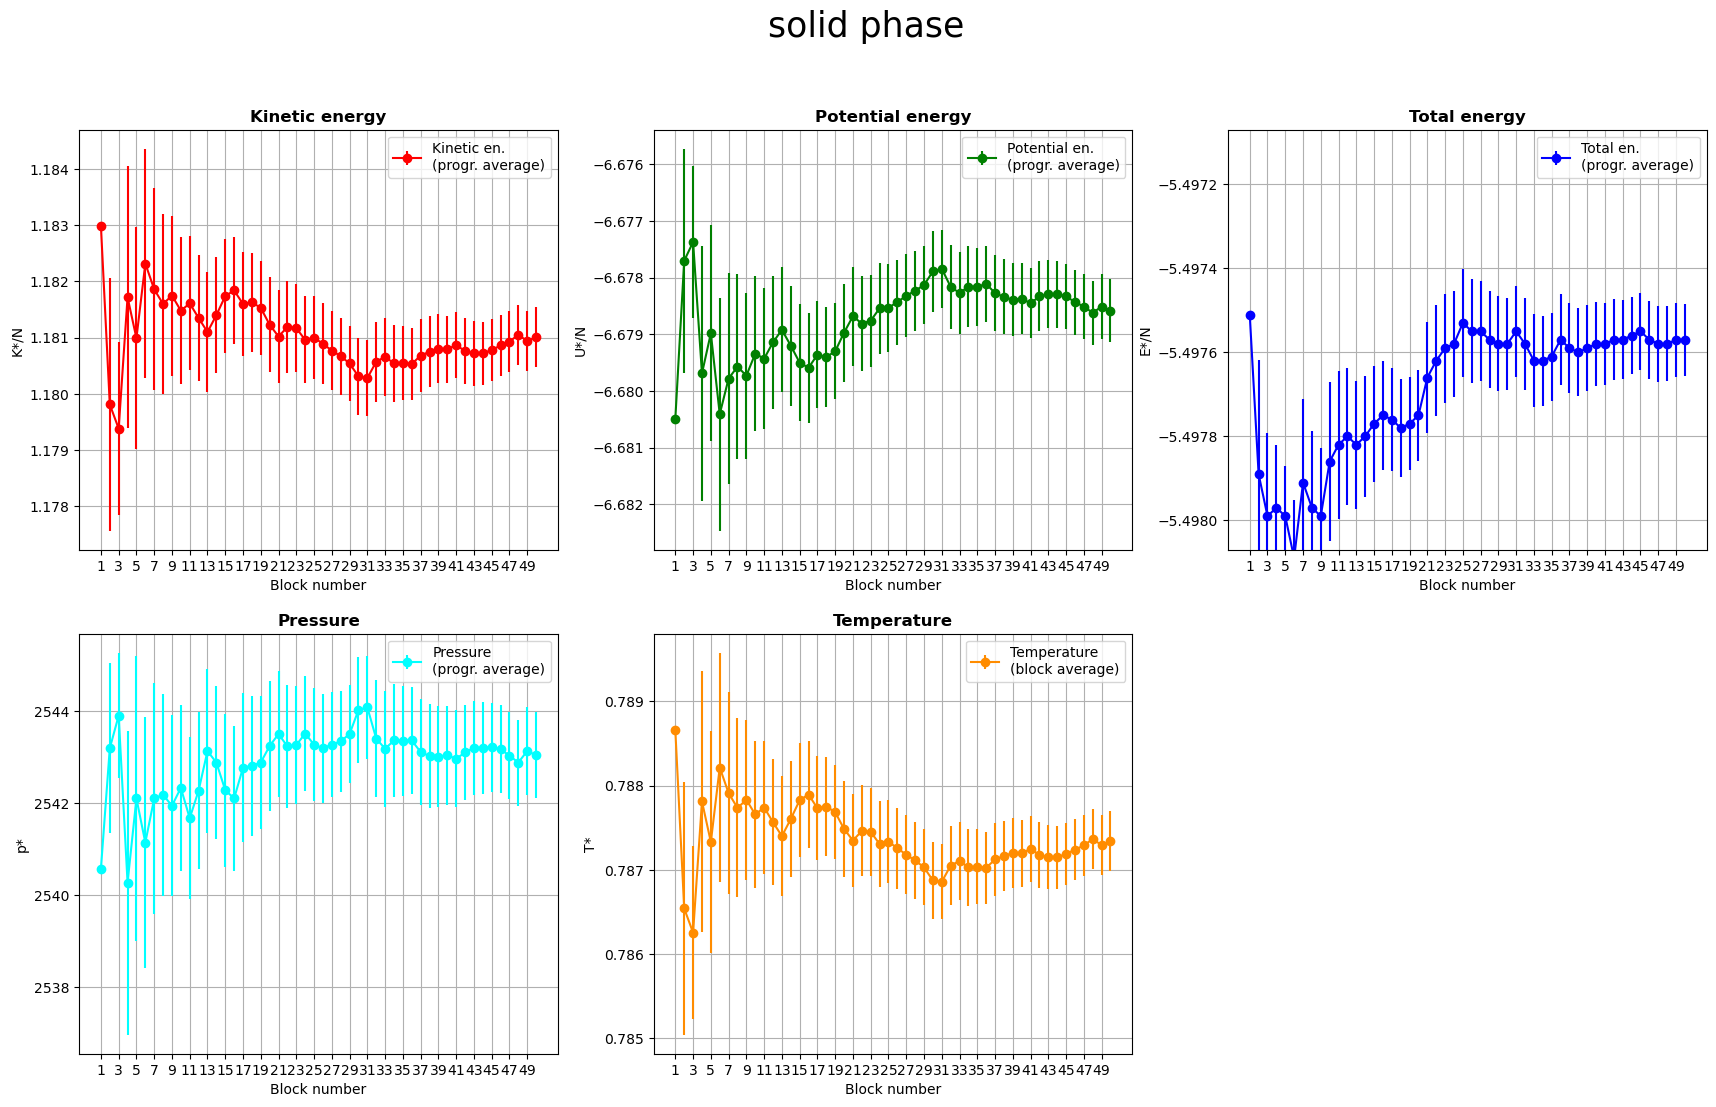

In [166]:
plotFigures("solid")

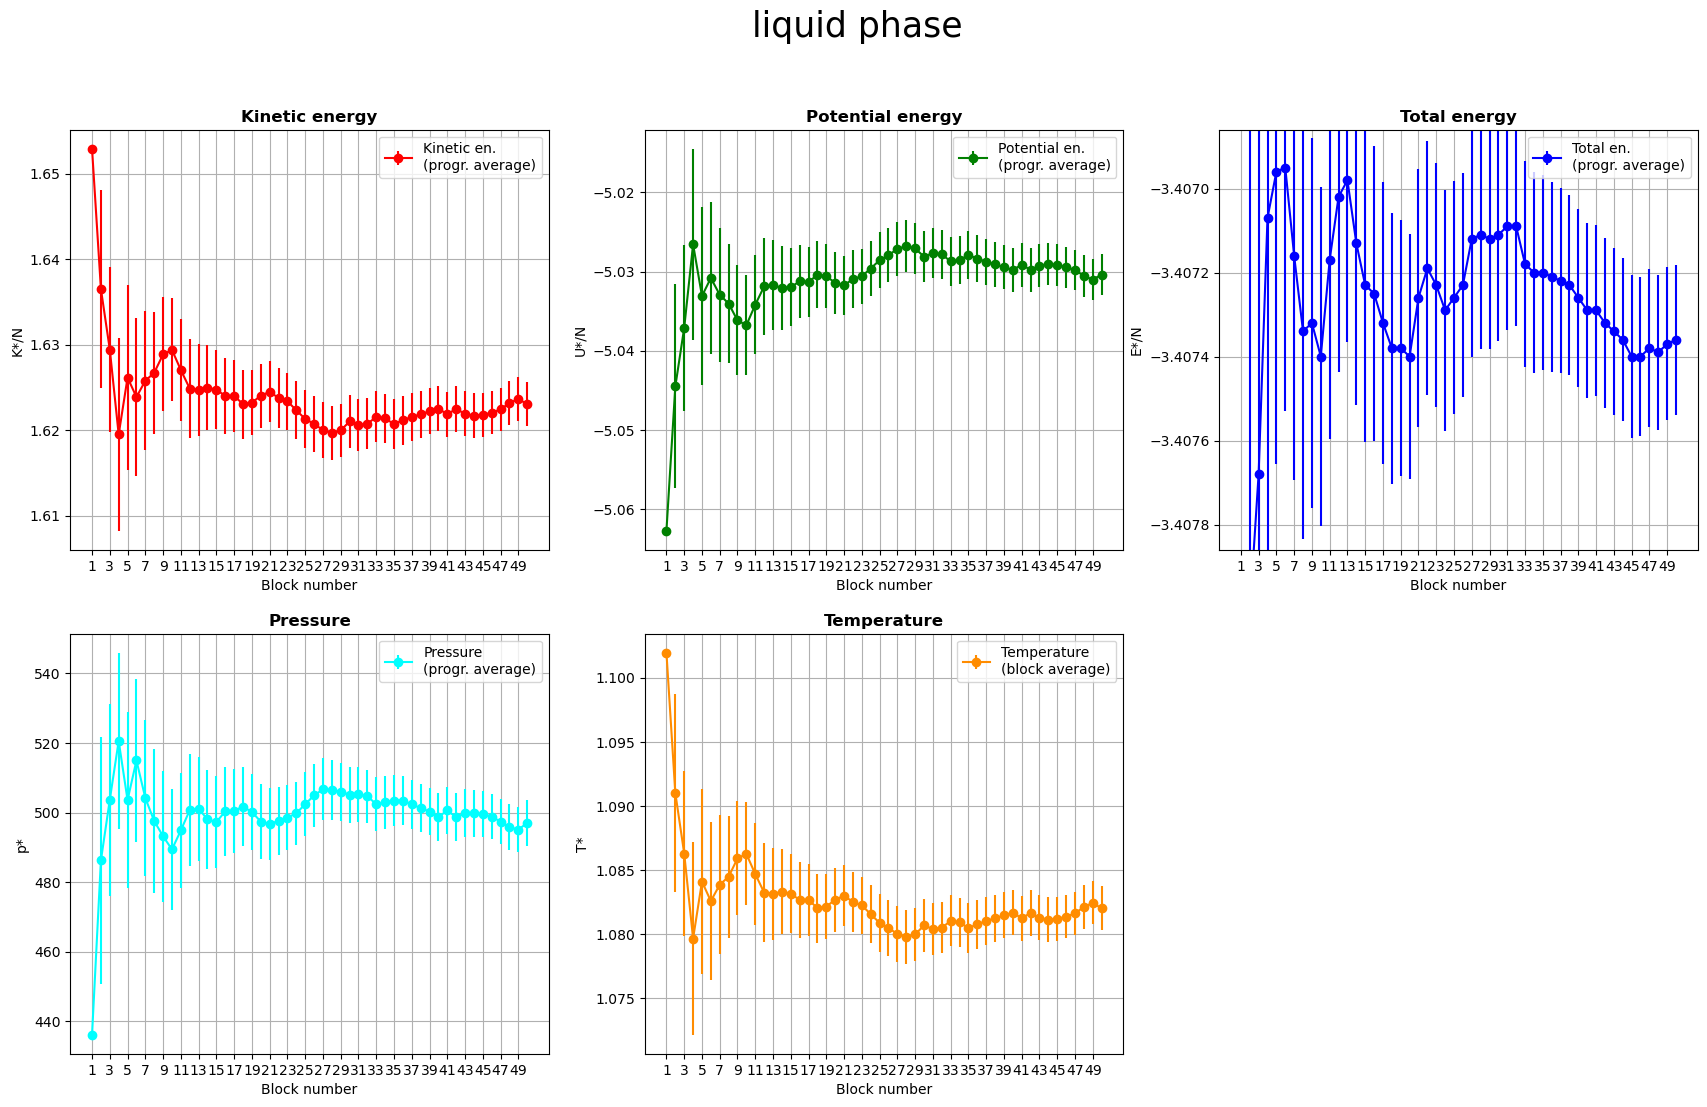

In [167]:
plotFigures("liquid")

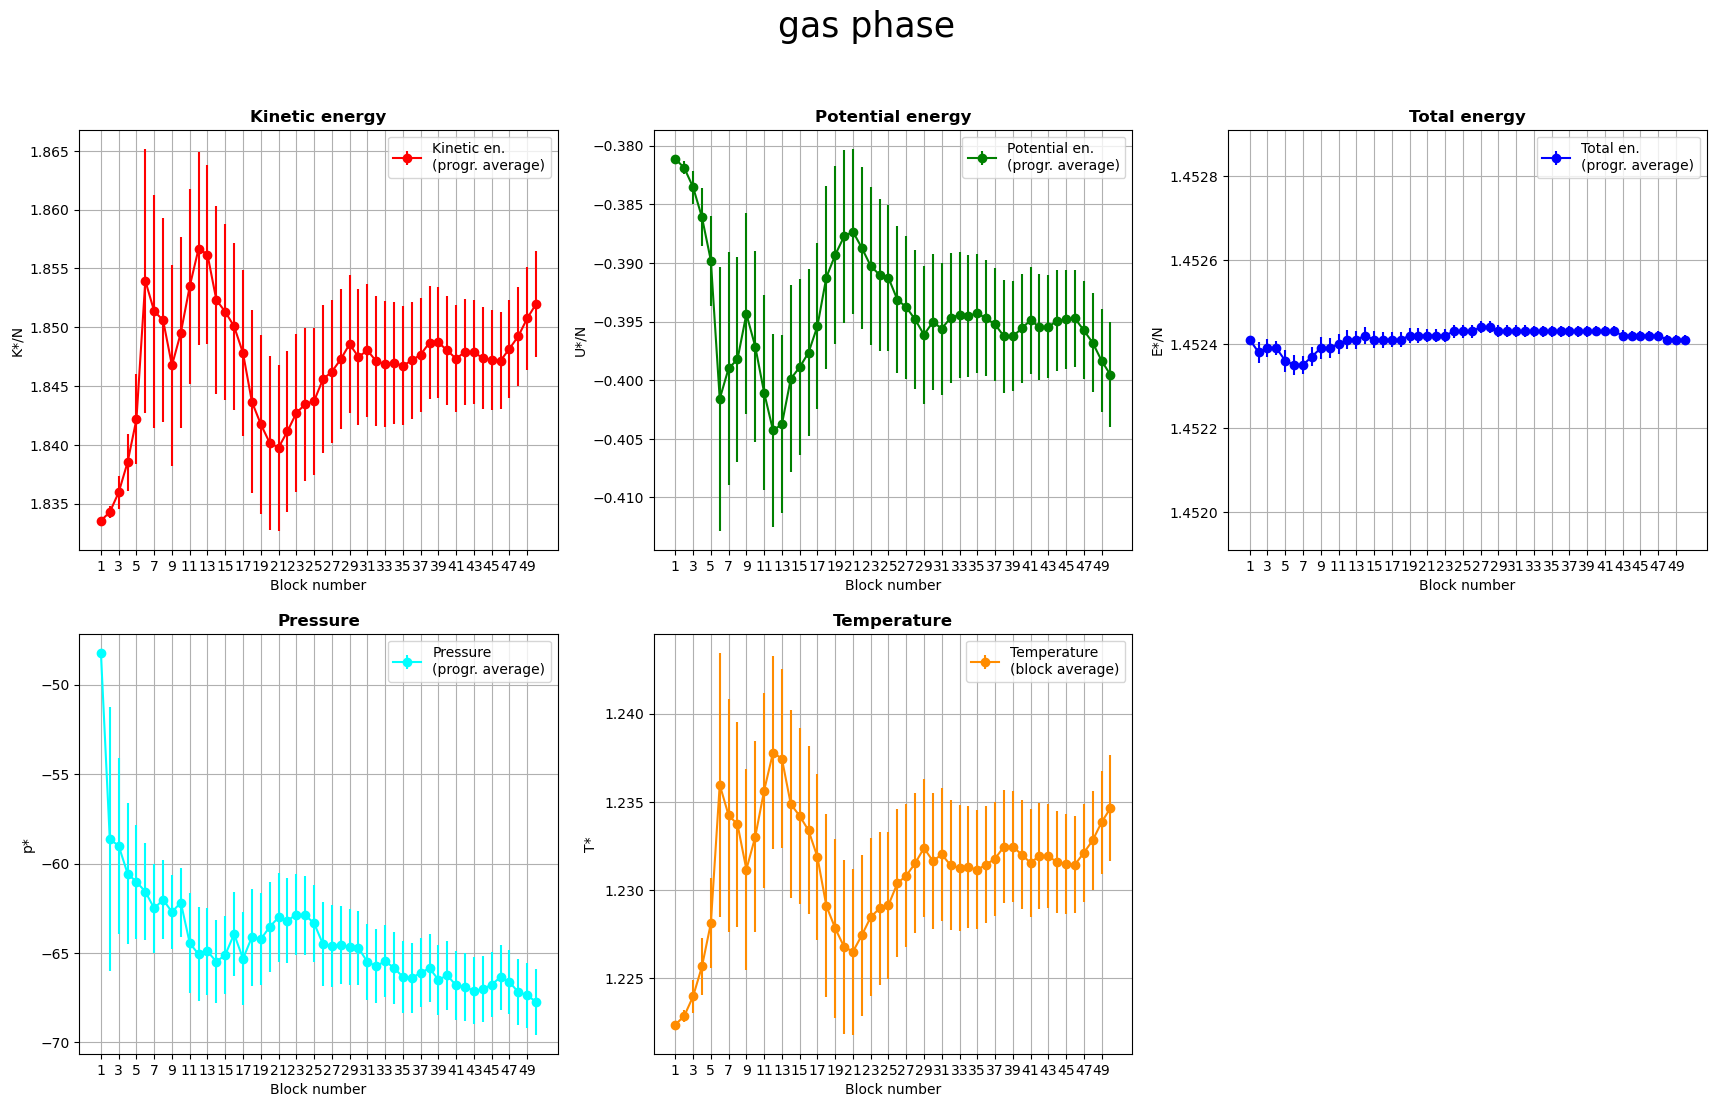

In [168]:
plotFigures("gas")

### Osservo che il sistema termalizza a temperature leggermente più basse, nelle fasi solida (0.787 invece che 0.8) e liquida (1.08 invece che 1.1), e leggermente più alte, nella fase gassosa (1.23 invece che 1.2), rispetto alla temperatura raggiunta durante l'equilibrazione. Una possibile spiegazione è che l'equilibrazione è avvenuta su tempi molto più brevi rispetto alla simulazione vera e propria. Pertanto è possibile che il sistema abbia ancora la possibilità di fluttuare rispetto al valore di equilibrio raggiunto, e dunque non termalizza esattamente alla temperatura indicata inizialmente.

# Calcolo della funzione di distribuzione radiale

Ho successivamente il calcolo della funzione di distribuzione radiale, $g(r)$, come funzione della distanza radiale $ r $ tra le particelle, con $ r $ in $\left[ 0; \frac{L}{2}\right] $, all'interno del codice del simulatore NSL, calcolando valore medio di $g(r)$in ciascun blocco, valore medio finale di $ g(r) $ con incertezze statistiche in un file separato.

In [37]:

print('do you want to execute this program:')
answer = input('->  [yes| No]: ' )
if answer == 'yes' :
    for i in range (0,3) :
        setInitialConfig(phase[i],'equilibrazione/'+phase[i]+\
                         '/CONFIG/config.xyz',50,20)
        runSimulation(phase[i],'distRadiale/')

do you want to execute this program:


->  [yes| No]:  no


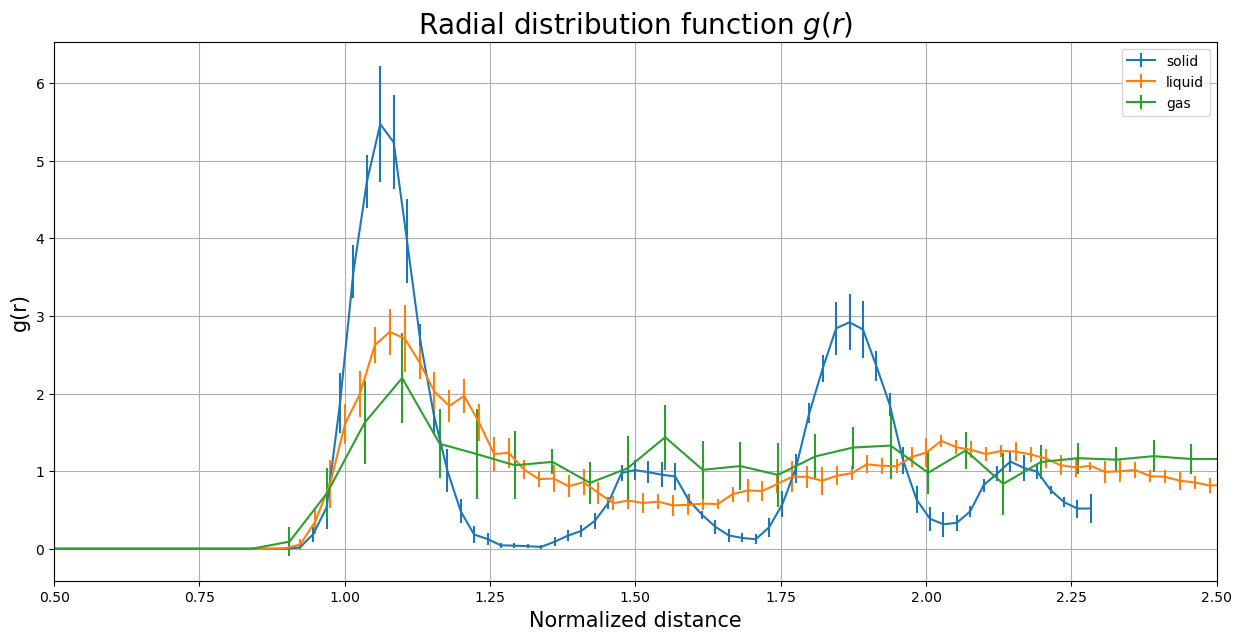

In [113]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

plt.figure(figsize=(15, 7))
x=np.arange(0,100)

# box scaling
rho = [1.1, 0.8, 0.05]
npart = 108
L = [0.0,0.0,0.0]
for i in range(3):
    L[i] = ((rho[i]/npart)**(-1/3))/200
    
for i in range (3):
        gdr = np.loadtxt("distRadiale/"+phase[i]+"/gofr.dat", usecols=range(0,100), unpack='true', max_rows=20)
        y = np.mean(gdr, axis=1)
        err = np.std(gdr, axis=1)
        plt.errorbar(x*L[i], y, err, marker='',label=phase[i] )
        plt.title("Radial distribution function $g(r)$", fontsize=20)
        plt.xlabel('Normalized distance', fontsize=15)
        plt.ylabel('g(r)', fontsize=15)
        plt.legend()
        plt.grid(True)
        plt.xlim(0.5,2.5)